In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel, StructuralCausalModel
import pylogit
from collections import OrderedDict
import pylogit as cm
from functools import reduce
import statsmodels.api as sm

from IPython import display

import os
os.listdir('.')

['Factor_Model_tuning.py',
 '.DS_Store',
 '.gitkeep',
 'Causal_Graph_Tim_Data.ipynb',
 'Factor_Model_tuning.ipynb',
 'spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv',
 '.ipynb_checkpoints',
 'Simple_Simulation.ipynb']

In [5]:
data = pd.read_csv('spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv')
data.columns

Index(['household_id', 'person_id', 'tour_id', 'observation_id', 'mode_id',
       'choice', 'tour_origin_taz', 'primary_dest_taz', 'total_travel_time',
       'total_travel_cost', 'total_travel_distance', 'age', 'household_size',
       'household_income', 'household_income_values', 'transit_subsidy',
       'transit_subsidy_amount', 'num_cars', 'num_licensed_drivers',
       'cross_bay', 'oakland_and_berkeley', 'survey_id', 'gender',
       'non_relative_flag', 'num_pre_school', 'num_school_aged', 'married',
       'parent', 'income_category_1', 'income_category_2', 'income_category_3',
       'income_category_4', 'income_category_5', 'income_category_6',
       'income_category_7', 'income_category_8', 'income_category_9',
       'income_category_10', 'income_unknown', 'ln_drive_cost',
       'ln_drive_cost_sq', 'total_travel_time_10x', 'total_travel_time_tenth',
       'high_income', 'medium_income', 'low_income', 'high_income_cost',
       'medium_income_cost', 'low_income_cost', 

In [6]:
### Just look at the drive alone mode
drive_alone_df = data[data['mode_id']==1]

### Only keep columns of interest 
drive_alone_df = drive_alone_df[[ 'total_travel_time', 'total_travel_cost',
                                 'total_travel_distance', 'household_size',
                               'num_cars', 'cross_bay']]

drive_alone_df.describe()


,total_travel_time,total_travel_cost,total_travel_distance,household_size,num_cars,cross_bay
count,3804.000000,3804.000000,3804.000000,3804.000000,3804.000000,3804.000000
mean,29.667137,3.289287,15.579498,3.359621,2.050999,0.056257
std,24.586569,4.214448,18.465879,1.378056,0.880458,0.230447
min,3.910000,0.074000,0.400000,1.000000,0.000000,0.000000
25%,12.450000,0.646325,3.497500,2.000000,1.000000,0.000000
50%,21.430000,1.428500,7.730000,3.000000,2.000000,0.000000
75%,38.147500,4.063700,21.257500,4.000000,2.000000,0.000000
max,201.010000,36.142500,157.150000,8.000000,8.000000,1.000000


## Assumed causal graph

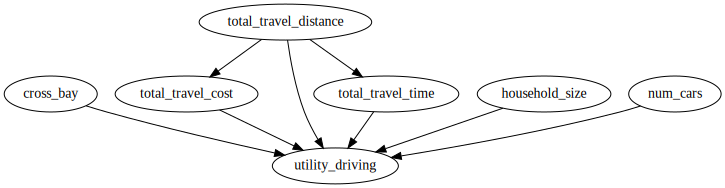

In [7]:
drive_alone_graph = CausalGraphicalModel(
    nodes=['total_travel_time', 'total_travel_cost', 'total_travel_distance', #'household_income',
          'household_size',  'num_cars', 'cross_bay', 'utility_driving'],
    edges=[
        ("total_travel_time", "utility_driving"), 
        ("total_travel_cost", "utility_driving"), 
        ("total_travel_distance", "utility_driving"), 
        ("household_size", "utility_driving"), 
#         ("household_income", "utility_driving"), 
        ("num_cars", "utility_driving"), 
        ("cross_bay", "utility_driving"), 
        
        
        ("total_travel_distance", "total_travel_time"), 
        ("total_travel_distance", "total_travel_cost"), 
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
drive_alone_graph.draw()

## Distributional regression
Assume univariate linear approximation for the relationship between travel distance and travel time/cost. Turns out it's not a horrible assumption.

In [8]:
def fit_regression(X, y, data, plotting = True):
    data_x = sm.add_constant(data[X])
    data_y = data[y]

    model = sm.OLS(data_y, data_x)
    
    results = model.fit()
    
    if plotting:
        fig = plt.figure(figsize=(12,8))
        fig = sm.graphics.plot_regress_exog(results, X[0], fig=fig)
    
    return results

/Users/hassanobeid/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      total_travel_cost   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                 4.850e+04
Date:                Sun, 15 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:03:58   Log-Likelihood:                -5883.1
No. Observations:                3804   AIC:                         1.177e+04
Df Residuals:                    3802   BIC:                         1.178e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.1347      0.024     -5.589      0.000      -0.182      -0.087
total_travel_distance     0.2198      0.001    220.231      0.000       0.218       0.222
==============================================================================
Omnibus:                     1585.600   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8216.409
Skew:                           1.952   Prob(JB):                         0.00
Kurtosis:                       9.050   Cond. No.                         31.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

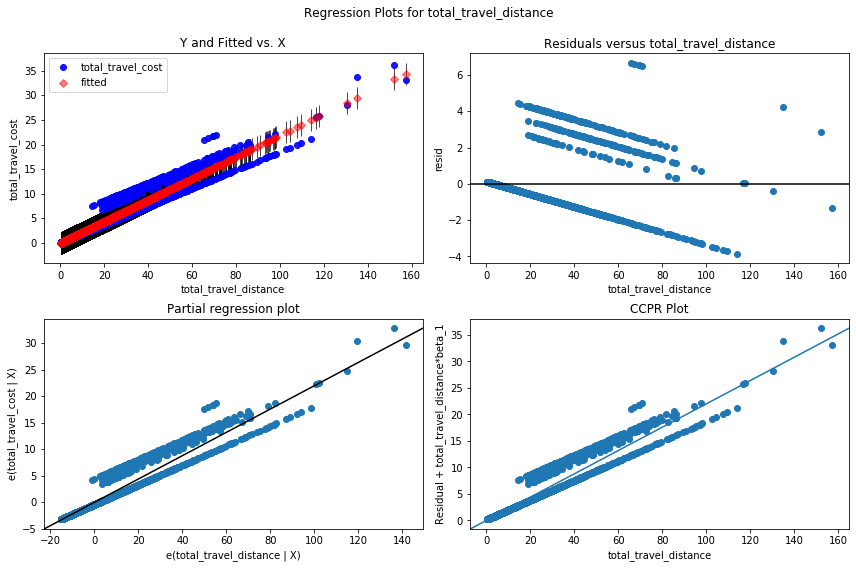

In [9]:
## Regress travel cost on travel distance

cost_on_distance_reg = fit_regression(X=['total_travel_distance'], 
                                      y = ['total_travel_cost'], data=drive_alone_df, plotting = True)

cost_on_distance_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      total_travel_time   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 5.666e+04
Date:                Sun, 15 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:03:59   Log-Likelihood:                -12316.
No. Observations:                3804   AIC:                         2.464e+04
Df Residuals:                    3802   BIC:                         2.465e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     9.5864      0.131     73.284      0.000       9.330       9.843
total_travel_distance     1.2889      0.005    238.036      0.000       1.278       1.300
==============================================================================
Omnibus:                      882.977   Durbin-Watson:                   1.679
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4147.419
Skew:                           1.042   Prob(JB):                         0.00
Kurtosis:                       7.672   Cond. No.                         31.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

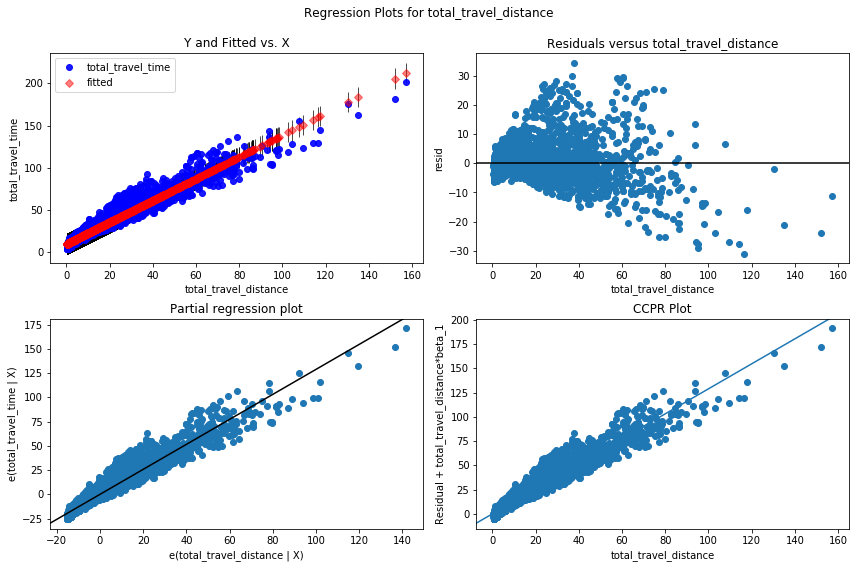

In [10]:
## Regress travel time on travel distance

time_on_distance_reg = fit_regression(X=['total_travel_distance'], 
                                      y = ['total_travel_time'], data=drive_alone_df, plotting = True)

time_on_distance_reg.summary()

### Simulate travel time and cost based on the distributional regression

In [11]:
## residuals spread -- assuming homoscedasticity
time_on_dist_std = time_on_distance_reg.resid.std()
cost_on_dist_std = cost_on_distance_reg.resid.std()

sample_size = len(drive_alone_df)

In [12]:
total_travel_time_sim = ( time_on_distance_reg.params[0] + 
                         time_on_distance_reg.params[1]*drive_alone_df['total_travel_distance']
                        + np.random.normal(loc=0, scale=time_on_dist_std, size = sample_size) )

total_travel_cost_sim = ( cost_on_distance_reg.params[0] + 
                         cost_on_distance_reg.params[1]*drive_alone_df['total_travel_distance']
                        + np.random.normal(loc=0, scale=cost_on_dist_std, size = sample_size) )

### Create a simulation dataframe

In [59]:
simulation_df = drive_alone_df.copy()
simulation_df['total_travel_time'] = total_travel_time_sim
simulation_df['total_travel_cost'] = total_travel_cost_sim

### Simulate the utility equation based on hypothetical parameters

In [60]:
simulation_df.columns

Index(['total_travel_time', 'total_travel_cost', 'total_travel_distance',
       'household_size', 'num_cars', 'cross_bay'],
      dtype='object')

In [61]:
## Assumed coefficients for above columns
coeffs = np.array([-.5, -1.5, 3, 5, 2, -7 ])
asc_drive = 6.

In [62]:
utilities = asc_drive + np.dot( simulation_df, coeffs) + np.random.normal(loc=0, scale = 1, size = sample_size)

simulation_df['utilities'] = utilities

## Estimation

Note that here, I'm treating the utilities as an observed quantity that I'm trying to estimate. This will get more complicated as we include different modes and actually try to maximize the correct likelihood function. 

The thing I need to point out here is that irrespective of our causal graph, we will always recover the paramters in coeffs (defined above) when we run the regression. The question becomes, are the coefficients on each of the variables (the true coefficients) causal? That depends on the causal graph:

- In the case of independent variables, the true causal effect of distance is the 0.1, the same value in the coeffs array. Thus, running a regression on all the variables in this case would return the true causal estimate. 

- In the case where travel cost and travel time are descendents of distance, the true causal effect of distance becomes: 0.1 - 0.5*(1.28) - 1.5*(0.22) = -0.87. We will only recover this value if we omit travel distance and travel time from the utility equation. Alternatively, we can keep them in the equation, but then don't assign the coefficient for distance any causal interpretation, and post-process the results (and make parametric assumptions!) to calculate the true causal effect. 

In [63]:
## Regress utilities on all the covariates. Notice how we recover the simulation parameters.
## The coefficient on travel distance however, is not causal
utilities_regress = fit_regression(X=list(simulation_df.columns[:-1]), 
                                      y = ['utilities'], data=simulation_df, plotting = False)
utilities_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              utilities   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 8.548e+05
Date:                Sun, 15 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:11:57   Log-Likelihood:                -5393.8
No. Observations:                3804   AIC:                         1.080e+04
Df Residuals:                    3797   BIC:                         1.085e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     6.0163      0.059    101.465      0.000       5.900       6.133
total_travel_time        -0.5014      0.003   -192.297      0.000      -0.507      -0.496
total_travel_cost        -1.4869      0.014   -104.298      0.000      -1.515      -1.459
total_travel_distance     2.9980      0.005    638.248      0.000       2.989       3.007
household_size            5.0053      0.013    392.620      0.000       4.980       5.030
num_cars                  1.9831      0.020    100.526      0.000       1.944       2.022
cross_bay                -6.9097      0.074    -93.315      0.000      -7.055      -6.765
==============================================================================
Omnibus:                        1.439   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.487   Jarque-Bera (JB):                1.421
Skew:                          -0.047   Prob(JB):                        0.491
Kurtosis:                       3.007   Cond. No.                         210.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
## Now regress utilities on all the covariates except for travel time and cost. 
## The coefficient on travel distance now is causal. However, this is not a good model of the output. 
X = [ 'total_travel_distance',
       'household_size', 'num_cars', 'cross_bay'
    ]

utilities_regress_causal = fit_regression(X=X, 
                                      y = ['utilities'], data=simulation_df, plotting = False)
utilities_regress_causal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              utilities   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 9.362e+04
Date:                Sun, 15 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:12:00   Log-Likelihood:                -10355.
No. Observations:                3804   AIC:                         2.072e+04
Df Residuals:                    3799   BIC:                         2.075e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.4778      0.198      7.448      0.000       1.089       1.867
total_travel_distance     2.0246      0.003    581.815      0.000       2.018       2.031
household_size            4.9756      0.047    105.966      0.000       4.884       5.068
num_cars                  2.0112      0.073     27.678      0.000       1.869       2.154
cross_bay                -6.7232      0.273    -24.665      0.000      -7.258      -6.189
==============================================================================
Omnibus:                        7.982   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.763
Skew:                          -0.061   Prob(JB):                       0.0125
Kurtosis:                       3.201   Cond. No.                         112.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## What if we don't observe travel distance?

### Fit PCA

In [65]:
import numpy as np
from numpy.random import randn, rand
from scipy.optimize import minimize
import matplotlib.pyplot as plt
# from nnls import nnlsm_blockpivot as nnlstsq
import itertools
from scipy.spatial.distance import cdist

def censored_lstsq(A, B, M):
    """Solves least squares problem with missing data in B
    Note: uses a broadcasted solve for speed.
    Args
    ----
    A (ndarray) : m x r matrix
    B (ndarray) : m x n matrix
    M (ndarray) : m x n binary matrix (zeros indicate missing values)
    Returns
    -------
    X (ndarray) : r x n matrix that minimizes norm(M*(AX - B))
    """

    if A.ndim == 1:
        A = A[:,None]

    # else solve via tensor representation
    rhs = np.dot(A.T, M * B).T[:,:,None] # n x r x 1 tensor
    T = np.matmul(A.T[None,:,:], M.T[:,:,None] * A[None,:,:]) # n x r x r tensor
    try:
        # transpose to get r x n
        return np.squeeze(np.linalg.solve(T, rhs), axis=-1).T
    except:
        r = T.shape[1]
        T[:,np.arange(r),np.arange(r)] += 1e-6
        return np.squeeze(np.linalg.solve(T, rhs), axis=-1).T



def cv_pca(data, rank, M=None, p_holdout=0.3, nonneg=False, iterations = 1000):
    """Fit PCA while holding out a fraction of the dataset.
    """

#     # choose solver for alternating minimization
#     if nonneg:
#         solver = censored_nnlstsq
#     else:
    solver = censored_lstsq

    # create masking matrix
    if M is None:
        M = np.random.rand(*data.shape) > p_holdout

    # initialize U randomly
    if nonneg:
        U = np.random.rand(data.shape[0], rank)
    else:
        U = np.random.randn(data.shape[0], rank)

    # fit pca/nmf
    for itr in range(iterations):
        Vt = solver(U, data, M)
        U = solver(Vt.T, data.T, M.T).T

    # return result and test/train error
    resid = np.dot(U, Vt) - data
    train_err = np.mean(resid[M]**2)
    test_err = np.mean(resid[~M]**2)
    return U, Vt, train_err, test_err, M, resid

In [75]:
X_columns = [
    'total_travel_time',
       'total_travel_cost', 
            ]


X = np.array((simulation_df[X_columns] - simulation_df[X_columns].mean())/simulation_df[X_columns].std())


# X_raw = np.array([s2,s3]).reshape((1000,2))
# X =( X_raw - X_raw.mean(axis=0) )/X_raw.std(axis=0)


U, Vt, train_err, test_err, M, resid = cv_pca(data=X, rank=2)
train_err, test_err

(1.3724735328392512e-07, 0.8351306586507644)

### Check PCA

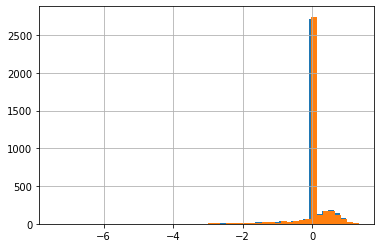

In [76]:
fig, ax = plt.subplots()
display.display(pd.Series(resid[:,0]).hist(bins=50))

# fig, ax = plt.subplots()
display.display(pd.Series(resid[:,1]).hist(bins=50))

## Include confounder in regression

In [80]:
simulation_df['confounder_PCA'] = U[:,1]

In [81]:
X_conf = ['total_travel_time', 'total_travel_cost', 
       'household_size', 'num_cars', 'cross_bay', 
       'confounder_PCA']


utilities_regress = fit_regression(X=X_conf, 
                                      y = ['utilities'], data=simulation_df, plotting = False)
utilities_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              utilities   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     7268.
Date:                Sun, 15 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:18:05   Log-Likelihood:                -14304.
No. Observations:                3804   AIC:                         2.862e+04
Df Residuals:                    3797   BIC:                         2.867e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.1827      0.657     -3.324      0.001      -3.470      -0.895
total_travel_time     0.6919      0.019     36.376      0.000       0.655       0.729
total_travel_cost     4.5448      0.126     35.941      0.000       4.297       4.793
household_size        4.5827      0.132     34.591      0.000       4.323       4.842
num_cars              2.4762      0.205     12.072      0.000       2.074       2.878
cross_bay            -4.0970      0.769     -5.327      0.000      -5.605      -2.589
confounder_PCA        0.0154      0.020      0.777      0.437      -0.023       0.054
==============================================================================
Omnibus:                        9.126   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.962
Skew:                           0.072   Prob(JB):                      0.00687
Kurtosis:                       3.205   Cond. No.                         186.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
X_true = ['total_travel_time', 'total_travel_cost', 
       'household_size', 'num_cars', 'cross_bay', 
       'total_travel_distance']


utilities_regress = fit_regression(X=X_true, 
                                      y = ['utilities'], data=simulation_df, plotting = False)
utilities_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              utilities   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 8.548e+05
Date:                Sun, 15 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:18:21   Log-Likelihood:                -5393.8
No. Observations:                3804   AIC:                         1.080e+04
Df Residuals:                    3797   BIC:                         1.085e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     6.0163      0.059    101.465      0.000       5.900       6.133
total_travel_time        -0.5014      0.003   -192.297      0.000      -0.507      -0.496
total_travel_cost        -1.4869      0.014   -104.298      0.000      -1.515      -1.459
household_size            5.0053      0.013    392.620      0.000       4.980       5.030
num_cars                  1.9831      0.020    100.526      0.000       1.944       2.022
cross_bay                -6.9097      0.074    -93.315      0.000      -7.055      -6.765
total_travel_distance     2.9980      0.005    638.248      0.000       2.989       3.007
==============================================================================
Omnibus:                        1.439   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.487   Jarque-Bera (JB):                1.421
Skew:                          -0.047   Prob(JB):                        0.491
Kurtosis:                       3.007   Cond. No.                         210.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
X_ommitted = ['total_travel_time', 'total_travel_cost', 
       'household_size', 'num_cars', 'cross_bay', 
       ]


utilities_regress = fit_regression(X=X_ommitted, 
                                      y = ['utilities'], data=simulation_df, plotting = False)
utilities_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              utilities   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     8723.
Date:                Sun, 15 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:18:22   Log-Likelihood:                -14304.
No. Observations:                3804   AIC:                         2.862e+04
Df Residuals:                    3798   BIC:                         2.866e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.3874      0.602     -3.969      0.000      -3.567      -1.208
total_travel_time     0.6937      0.019     36.741      0.000       0.657       0.731
total_travel_cost     4.5927      0.110     41.614      0.000       4.376       4.809
household_size        4.5812      0.132     34.585      0.000       4.321       4.841
num_cars              2.4757      0.205     12.071      0.000       2.074       2.878
cross_bay            -4.0932      0.769     -5.322      0.000      -5.601      -2.585
==============================================================================
Omnibus:                        9.357   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               10.246
Skew:                           0.073   Prob(JB):                      0.00596
Kurtosis:                       3.208   Cond. No.                         179.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Scratch

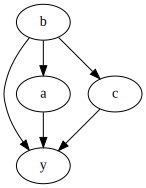

In [32]:
scratch = CausalGraphicalModel(
    nodes=['a', 'b', 'c', 'y'],
    edges=[
        ("b", "a"), 
        ("b", "c"), 
        ("b", "y"), 
        ("a", "y"), 
        ("c", "y"), 
 
 
    ]
)

scratch.draw()

In [45]:
size = 2000

b = np.random.normal(loc=10, scale = 2, size = size)

a = np.random.normal(loc=0, scale = 1, size = size) + 2  + 3*b 

c =  np.random.normal(loc=0, scale = 1, size = size) - 3 - 7*b 

y = 6 - 7*b + 3*a -2*c + np.random.normal(loc=0, scale = 1, size = size)

In [163]:
regress_df = pd.DataFrame()

regress_df['a'] = a
regress_df['b'] = b
regress_df['c'] = c
regress_df['y'] = y

mod_scratch = sm.OLS(regress_df['y'], sm.add_constant(regress_df[['b']]))
res = mod_scratch.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                 1.416e+05
Date:                Wed, 11 Mar 2020   Prob (F-statistic):               0.00
Time:                        16:03:51   Log-Likelihood:                -5522.1
No. Observations:                2000   AIC:                         1.105e+04
Df Residuals:                    1998   BIC:                         1.106e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.0740      0.434     41.617      0.000      17.222      18.926
b             15.9916      0.043    376.249      0.000      15.908      16.075
==============================================================================
Omnibus:                        0.755   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.686   Jarque-Bera (JB):                0.766
Skew:                          -0.047   Prob(JB):                        0.682
Kurtosis:                       2.985   Cond. No.                         52.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""